In [3]:
%cd ../

/Users/yasmin/paper/FederatedLearning


## 3D Road Network Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../algorithm1.png)

In [4]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        prev_w = np.copy(new_w)

        # algorithm 1, line 2
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6

                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], hat_w[i], datapoints[i]['degree'])

            else:
                new_w[i] = hat_w[i]

        # algorithm 1, line 9
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # algorithm 1, line 10
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


### FedAvg

In [5]:
from sklearn.metrics import mean_squared_error

from algorithm.penalty import *


def fedAvg(K, datapoints, true_labels, calculate_score=False):
    '''
    :param K: the number of iterations
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    N = len(datapoints)
    m, n = datapoints[0]['features'].shape

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the weights
    '''

    iteration_scores = []
    for iterk in range(K):
        for i in range(N):
            optimizer = datapoints[i]['optimizer']
            new_w[i] = optimizer.optimize(
                datapoints[i]['features'], 
                datapoints[i]['label'], 
                new_w[i], 
                datapoints[i]['degree']
            )
        new_w[:, :] = np.mean(new_w, axis=0)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w




### Primal Update 

As you see in the algorithm picture, the primal update needs a optimizer operator for the sampling set (line 6). We have implemented the optimizers discussed in the paper, both the logistic loss and squared error loss optimizers implementations with pytorch is available, also we have implemented the squared error loss optimizer using the fixed point equation in the `Networked Linear Regression` section of the paper.  

In [5]:
# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC


# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(40):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


### Dual Update 

As mentioned in the paper, the dual update has a penalty function(line 10) which is either norm1, norm2, or mocha.

In [6]:
# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Load 3D Road Data

This dataset is constructed by adding elevation information to the [3D road 
network in North Jutland, Denmark](https://archive.ics.uci.edu/ml/datasets/3D+Road+Network+(North+Jutland,+Denmark)#) (covering a region of 185 × 135 km2), 
containing LATITUDE, LONGITUDE, and also ALTITUDE of regions. 

In [7]:
def load_data(data_path='data/3D_spatial_network.txt'):
    with open(data_path, 'r') as f:
        data = f.read().split('\n')
    data = data[:-1]
    data = data[:1000]
    fixed_data = []
    for item in data:
        item = item.split(',')
        item0, item1, item2, item3 = float(item[0]), float(item[1]), float(item[2]), float(item[3])
        fixed_data.append(((item1, item2), item3))

    fixed_data = list(set(fixed_data))
    return fixed_data


## Create 3D Road Graph

We consider a graph G represents this dataset, which its nodes are the regions of the dataset and are connected 
by edges to their nearby neighbours with the weights that are 
related to the distances between them. So the feature vector $X^{(i)}∈ R^{1*2}$ of node $i \in V$ contains 
the latitude and longitude of its corresponding region, and the label $y^{(i)} \in R$ is its altitudes.

In [8]:
import numpy as np
from collections import defaultdict, Counter
from math import sqrt

def get_graph_data(data):
    '''
    :param data: a list containig the 3d road dataset data, whith the format of ((LATITUDE, LONGITUDE), ALTITUDE)

    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return datapoints: a dictionary containing the data of each node needed for the algorithm 1
    :return true_labels: a list containing the true labels of the nodes
    '''
    

    MAX_DIST = 0.05
    '''
    MAX_DIST: the threshhold for keeping the edges
    '''
    neighbours = defaultdict(list)
    '''
    neighbours: a dict containing the neighbors of each node
    '''
    for i in range(len(data)):
        lat1, long1 = data[i][0]
        
        for j in range(i + 1, len(data)):
            lat2, long2 = data[j][0]
            
            dist = sqrt((lat1 - lat2) ** 2 + (long1 - long2) ** 2)
            '''
            dist: the distance between the region i and the region j
            '''
            
            if dist >= MAX_DIST:
                continue
                
            if dist == 0:
                continue
                
            if ((lat2, long2), dist) in neighbours[(lat1, long1)]:
                continue
            
            # normalize the distance 
            dist *= 100
            
            neighbours[(lat1, long1)].append(((lat2, long2), 1/dist))


    E = 0
    '''
    E: number of edges of the graph
    '''
    degrees = Counter()
    '''
    degrees: the node degree for each region
    '''
    for item1, _ in data:
        # sort the neighbours of the region and select its top 10
        neighbours[item1] = sorted(neighbours[item1], key=lambda x: x[1], reverse=True)
        neighbours[item1] = neighbours[item1][:10]
        
        for item2, dist in neighbours[item1]:
            degrees[item1] += 1
            degrees[item2] += 1
            E += 1
            

    # using the regions that have at least one neighbour 
    cnt = 0
    node_indices = {}
    for (lat, log), _ in data:
        
        if degrees[(lat, log)] == 0:
            continue
        if (lat, log) in node_indices:
            continue
            
        node_indices[(lat, log)] = cnt
        cnt += 1

    # create B and weight_vec
    N = len(node_indices)
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph
    '''
    
    cnt = 0
    for item1 in neighbours:
        if item1 not in node_indices:
            continue
        
        idx1 = node_indices[item1]
        
        for item2, dist in neighbours[item1]:
            if item2 not in node_indices:
                continue
            
            idx2 = node_indices[item2]
            
            if idx1 < idx2:
                B[cnt, idx1] = 1

                B[cnt, idx2] = -1
            
            else:
                B[cnt, idx1] = -1

                B[cnt, idx2] = 1
            
            weight_vec[cnt] = dist
            cnt += 1
    B = B[:cnt, :]
    weight_vec = weight_vec[:cnt]
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    '''
    true_labels = []
    '''
    true_labels: a list containing the true labels of the nodes
    '''
    for item in data:
        lat, log = item[0]
        
        if (lat, log) not in node_indices:
            continue

        idx = node_indices[(lat, log)]
        
        features = np.array([[lat, log]])
        
        label = np.array([item[1]])
        true_labels.append(label)
        
        model = LinearModel(node_degrees[idx], features, label)
        optimizer = LinearOptimizer(model)

        datapoints[idx] = {
            'features': features,
            'degree': node_degrees[idx],
            'label': label,
            'optimizer': optimizer,
        }
        

    return B, weight_vec, datapoints, np.array(true_labels)



### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [23]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_MSE(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]

    true_labels = []
    pred_labels = []
    for i in range(len(datapoints)):
        features = np.array(datapoints[i]['features'])
        label = np.array(datapoints[i]['label'])
        true_labels.append(label)

        pred_labels.append(np.dot(features, predicted_w[i]))

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    alg1_MSE = {'total': mean_squared_error(true_labels, pred_labels),
                'train': mean_squared_error(true_labels[samplingset], pred_labels[samplingset]),
                'test': mean_squared_error(true_labels[not_samplingset], pred_labels[not_samplingset])}

    return alg1_MSE


def get_linear_regression_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return linear_regression_MSE : the MSE of linear regression for all the nodes, the samplingset and other nodes (test set)
    '''

    model = LinearRegression().fit(x[samplingset], y[samplingset])
    pred_y = model.predict(x)

    linear_regression_MSE = {'total': mean_squared_error(y, pred_y),
                             'train': mean_squared_error(y[samplingset],
                                                         pred_y[samplingset]),
                             'test': mean_squared_error(y[not_samplingset],
                                                        pred_y[not_samplingset])}

    return linear_regression_MSE


def get_decision_tree_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return decision_tree_MSE : the MSE of decision tree for all the nodes, the samplingset and other nodes (test set)
    '''

    max_depth = 2

    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor.fit(x[samplingset], y[samplingset])
    pred_y = regressor.predict(x)

    decision_tree_MSE = {'total': mean_squared_error(y, pred_y),
                         'train': mean_squared_error(y[samplingset],
                                                     pred_y[samplingset]),
                         'test': mean_squared_error(y[not_samplingset],
                                                    pred_y[not_samplingset])}
    return decision_tree_MSE


def get_scores(datapoints, predicted_w, fl_w, samplingset, others=True):
    N = len(datapoints)
    '''
    N : the total number of nodes
    '''

    # calculate algorithm1 MSE
    alg_1_score = get_algorithm1_MSE(datapoints, predicted_w, samplingset)
    fl_score = get_algorithm1_MSE(datapoints, fl_w, samplingset)
    
    linear_regression_score = None
    decision_tree_score = None

    if others:
        # prepare the data for calculating the linear regression and decision tree regression MSEs
        X = []
        '''
        X: an array containing the features of all the nodes
        '''
        true_labels = []
        '''
        true_labels: an array containing the labels of all the nodes
        '''
        for i in range(len(datapoints)):
            X.append(np.array(datapoints[i]['features']))
            true_labels.append(np.array(datapoints[i]['label']))

        X = np.array(X)
        true_labels = np.array(true_labels)
        m, n = X[0].shape

        x = X.reshape(-1, n)
        y = true_labels.reshape(-1, 1)

        reformated_samplingset = []
        for item in samplingset:
            for i in range(m):
                reformated_samplingset.append(m * item + i)
        reformated_not_samplingset = [i for i in range(m * N) if i not in reformated_samplingset]
        
        # calculate linear regression MSE
        linear_regression_score = get_linear_regression_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

        # calculate decision tree MSE
        decision_tree_score = get_decision_tree_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

    return alg_1_score, fl_score, linear_regression_score, decision_tree_score

### 3d Road experiment

We use Algorithm 1 to learn the weight vectors $w^{(i)}$ for a localized linear model. We assume that labels $y^{(i)}$ are available for 30% of the graph nodes, thus, for 70% of the nodes in G we do not know the labels but predict them with the weight vectors $\hat{w}^{(i)}$ obtained from Algorithm 1 (using a fixed number of 1000 iterations, and λ = 0.2).
We compare the MSE of our method with simple linear regression 
and decision tree regression.

In [24]:
import random 
import matplotlib.pyplot as plt

from collections import defaultdict


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

lambda_lasso = 0.2

K = 1000

raw_data = load_data()

B, weight_vec, datapoints, true_labels = get_graph_data(raw_data)
E, N = B.shape

alg1_scores = defaultdict(list)
fl_scores = defaultdict(list)
linear_regression_scores = defaultdict(list)
decision_tree_scores = defaultdict(list)

num_tries = 5

from joblib import Parallel, delayed
import multiprocessing
def fun(penalty_func):
    samplingset = random.sample([j for j in range(N)], k=int(0.3* N)) 
    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func)
    _, fl_w = fedAvg(K, datapoints, true_labels)

    return penalty_func, get_scores(datapoints, predicted_w, fl_w, samplingset, penalty_func=='norm1')

num_cores = multiprocessing.cpu_count()



results = Parallel(n_jobs=num_cores)(delayed(fun)(penalty_func) for penalty_func in PENALTY_FUNCS 
                                         for i in range(num_tries))

for penalty_func, scores in results:
    alg1_score, fl_score, linear_regression_score, decision_tree_score = scores
    alg1_scores[penalty_func].append(alg1_score)
    fl_scores[penalty_func].append(fl_score)
    linear_regression_scores[penalty_func].append(linear_regression_score)
    decision_tree_scores[penalty_func].append(decision_tree_score)

algorithm 1, norm1: 
 mean train MSE: 0.023536763427717912 
 mean test MSE: 36.12275752865788
algorithm 1, norm2: 
 mean train MSE: 0.02397476291029491 
 mean test MSE: 30.610905534327106
algorithm 1, mocha: 
 mean train MSE: 2.0497582090395193e-05 
 mean test MSE: 30.056403165784342
federated learning: 
 mean train MSE: 382.71409826346394 
 mean test MSE: 381.70831401187104
linear regression: 
 mean train MSE: 283.62937432975656 
 mean test MSE: 291.63767060307225
decision tree: 
 mean train MSE: 161.72475375668745 
 mean test MSE: 186.99237642311837


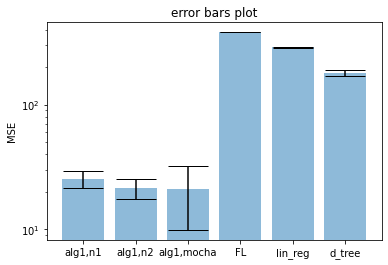

In [25]:
labels = ['alg1,n1', 'alg1,n2', 'alg1,mocha', 'FL', 'lin_reg', 'd_tree']
x_pos = np.arange(len(labels))
    
    
print('algorithm 1, norm1:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores['norm1']]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores['norm1']]))

print('algorithm 1, norm2:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores['norm2']]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores['norm2']]))

print('algorithm 1, mocha:', 
      '\n mean train MSE:', np.mean([item['train'] for item in alg1_scores['mocha']]),
      '\n mean test MSE:', np.mean([item['test'] for item in alg1_scores['mocha']]))  

print('federated learning:', 
      '\n mean train MSE:', np.mean([item['train'] for item in fl_scores['norm1']]),
      '\n mean test MSE:', np.mean([item['test'] for item in fl_scores['norm1']])) 
                                                                         
print('linear regression:', 
      '\n mean train MSE:', np.mean([item['train'] for item in linear_regression_scores['norm1']]),
      '\n mean test MSE:', np.mean([item['test'] for item in linear_regression_scores['norm1']]))

print('decision tree:', 
      '\n mean train MSE:', np.mean([item['train'] for item in decision_tree_scores['norm1']]),
      '\n mean test MSE:', np.mean([item['test'] for item in decision_tree_scores['norm1']]))
    
alg1_norm1_score = [item['total'] for item in alg1_scores['norm1']]
alg1_norm2_score = [item['total'] for item in alg1_scores['norm2']]
alg1_mocha_score = [item['total'] for item in alg1_scores['mocha']]  
fl_score = [item['total'] for item in fl_scores['norm1']]
linear_regression_score = [item['total'] for item in linear_regression_scores['norm1']]
decision_tree_score = [item['total'] for item in decision_tree_scores['norm1']]

mean_MSEs = [
    np.mean(alg1_norm1_score), 
    np.mean(alg1_norm2_score), 
    np.mean(alg1_mocha_score), 
    np.mean(fl_score), 
    np.mean(linear_regression_score), 
    np.mean(decision_tree_score)
]

std_MSEs = [
    np.std(alg1_norm1_score), 
    np.std(alg1_norm2_score),
    np.std(alg1_mocha_score), 
    np.std(fl_score), 
    np.std(linear_regression_score), 
    np.std(decision_tree_score)]


fig, ax = plt.subplots()
ax.bar(x_pos, mean_MSEs,
   yerr=std_MSEs,
   align='center',
   alpha=0.5,
   ecolor='black',
   capsize=20)
ax.set_ylabel('MSE')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_yscale('log')
ax.set_title('error bars plot')
plt.show()
plt.close()
    